This approach difference is that I added stops periods by floor, it was the most advanced feature that I had built.

Method:

In the feature engineering I calculated the standard deviation, mean and median per floor and day, and I assume that a small std the floor is closed, and I identified different periods of closes in the floors, maybe because vacation, or building problem, or reform. 

I observed that stop times can along for weeks. Test dataset has oposite weeks than train dataset, so I infer that if the week for prediction is between two stopped weeks, this week is stopped too, and weeks in the beggining or in the end, I assume the position of the previous week. Test dataset has the same floors of the train dataset, but has another different floors too. For unknown floors I assume as stop dates only weekends and holidays.

Final model XGBoost with Randon Forests (https://xgboost.readthedocs.io/en/latest/tutorials/rf.html)

I would say thank you for the challenge, was really nice to solve. :)


In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import cross_val_predict
from xgboost import plot_importance
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import metrics
from math import sqrt


## I built this object for centralize feature engineering, 
## as you can see I generated a lot of features and I tested a lot of combinations.
import data_preparation_v5 as dp

In [2]:
### Preparing Data for Training the model

df_train = dp.data_prep('GBS Building Attendance  - Train.csv')

Starting....
Running....
Finished....


In [3]:
## To diferenciate weekends and holidays of stops in business days

def stops_busday(df):
    if df['busday'] == 1:
        stops = 2
    else:
        stops = df['stops']
        
    return stops
        

df_train['stops'] = df_train[['busday', 'stops']].apply(stops_busday, axis=1)

In [4]:
df_train['stops'].value_counts()

0    108596
2     55800
1      8150
Name: stops, dtype: int64

In [5]:
#### Final Feature selection for Training

x2 = df_train[['building_floor_number', 'number_of_metro_1', 'number_of_rer_a', 'hour', 'week_number', 'weekday',  'stops']]

y = df_train[['attendance']]

In [6]:
### XGBoost
xgb = XGBRegressor(colsample_bytree=0.9,
                   gamma=0.3,
                   max_depth=9, 
                   min_chils_weight=4, 
                   subsample=1, 
                   n_estimators=40, 
                   nthread=-1, 
                   learning_rate=0.3,
                   num_parallel_tree=90,
                   importance_type='gain',
                   eval_metric='rmse')

In [7]:
# Evaluating the performace of model 2

prediction = cross_val_predict(xgb, x2, y, cv=5)


In [8]:
print('MAE:', metrics.mean_absolute_error(y, prediction))
print('RMSE:', sqrt(metrics.mean_squared_error(y, prediction)))
print('------------------------------')

result = pd.DataFrame()

result['prediction'] = prediction
# if prediction is negative put zero
result['prediction'] = result['prediction'].apply(lambda x: x if x > 0 else 0)

print('MAE:', metrics.mean_absolute_error(y, result['prediction']))
print('RMSE:', sqrt(metrics.mean_squared_error(y, result['prediction'])))

MAE: 8.848897329459394
RMSE: 17.351362739554567
------------------------------
MAE: 8.769534142706778
RMSE: 17.32255316682765


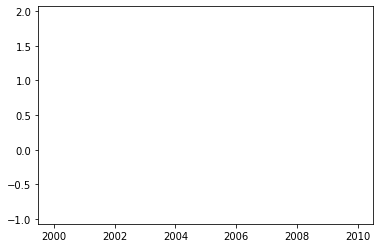

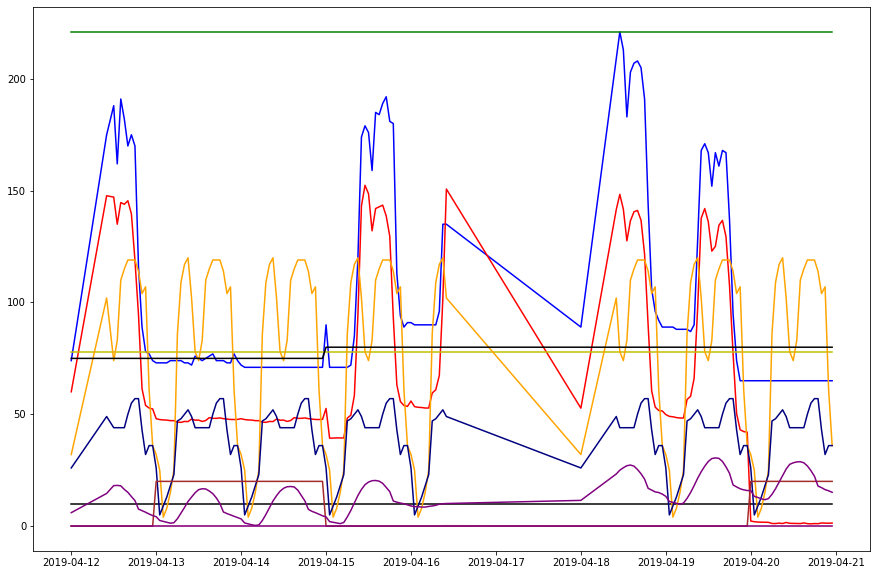

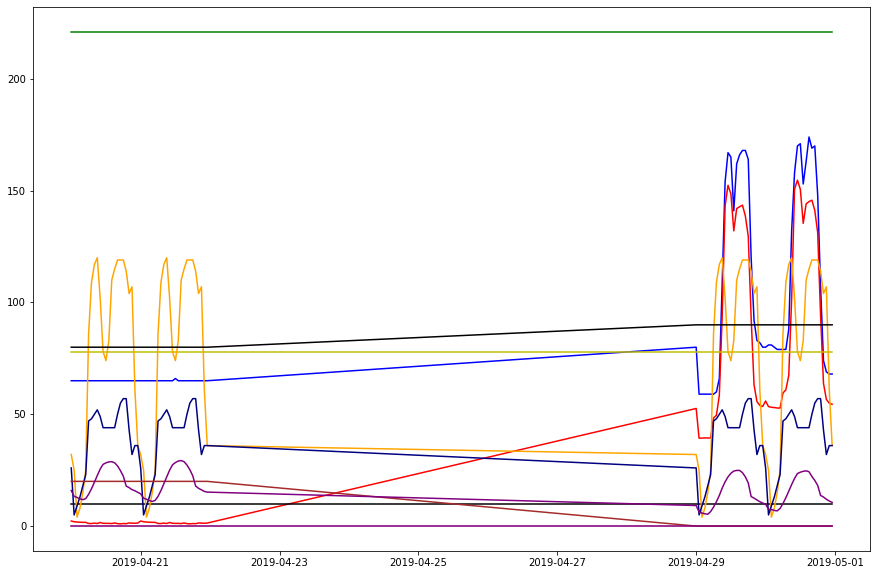

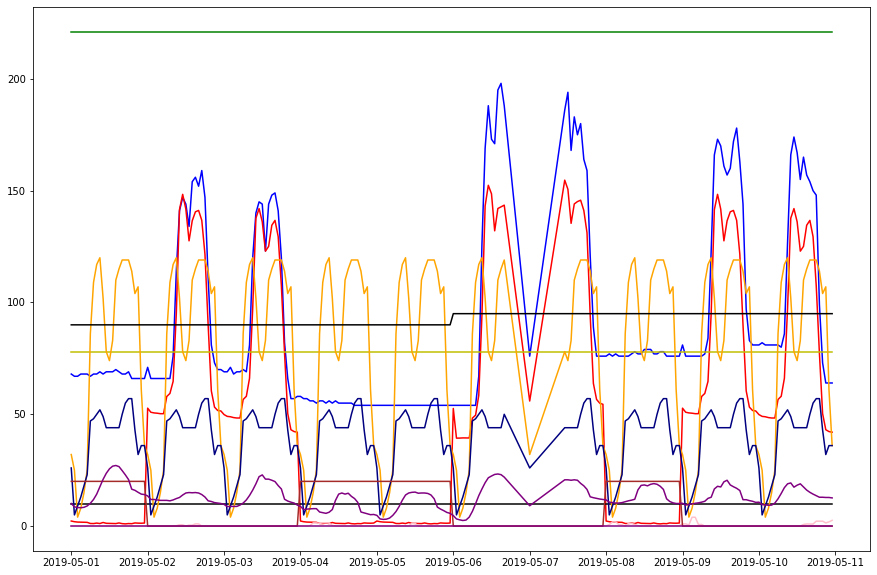

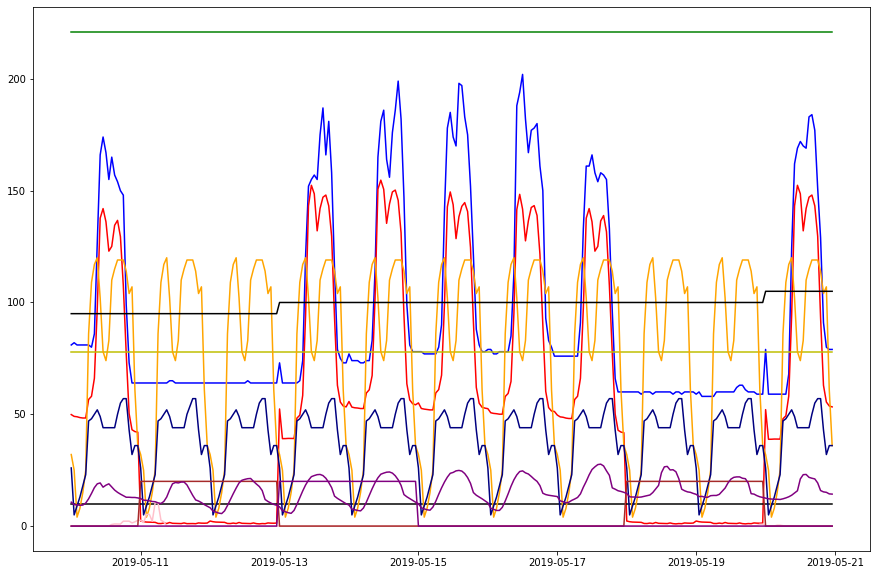

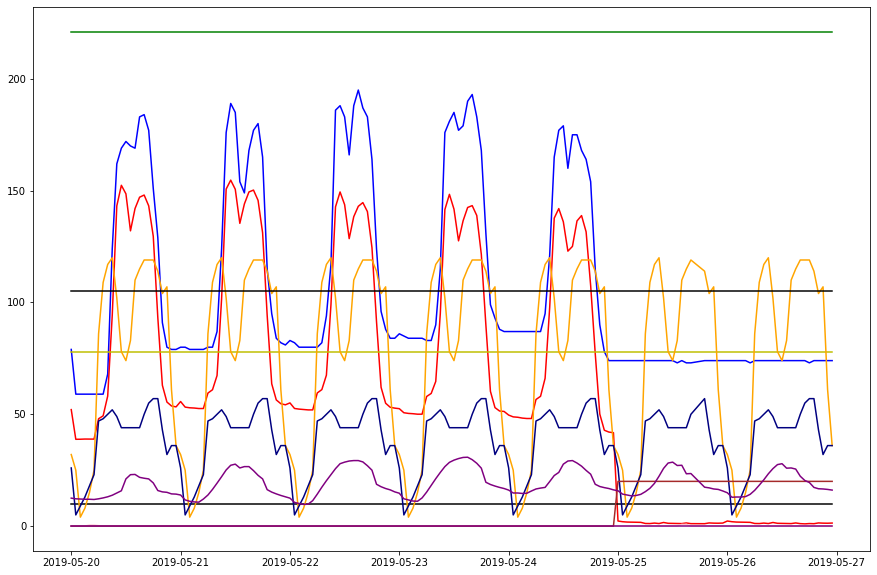

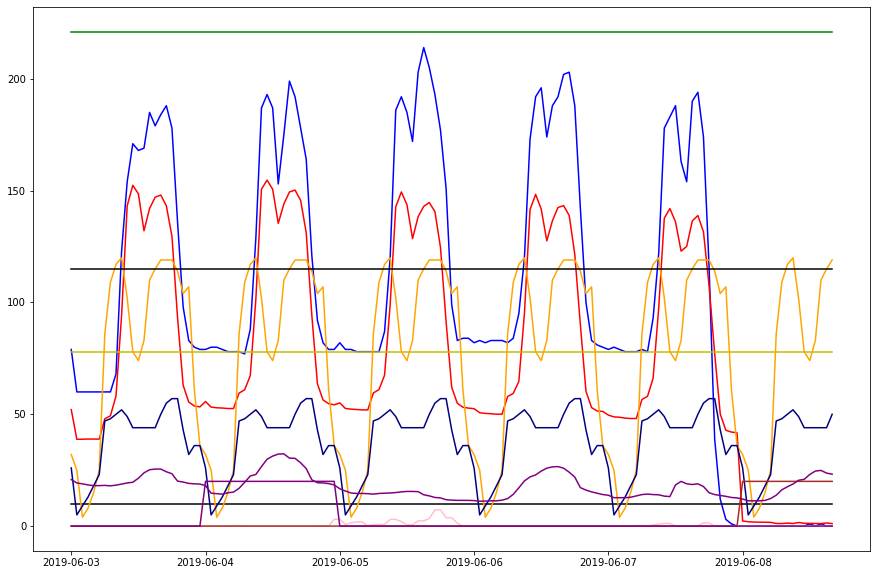

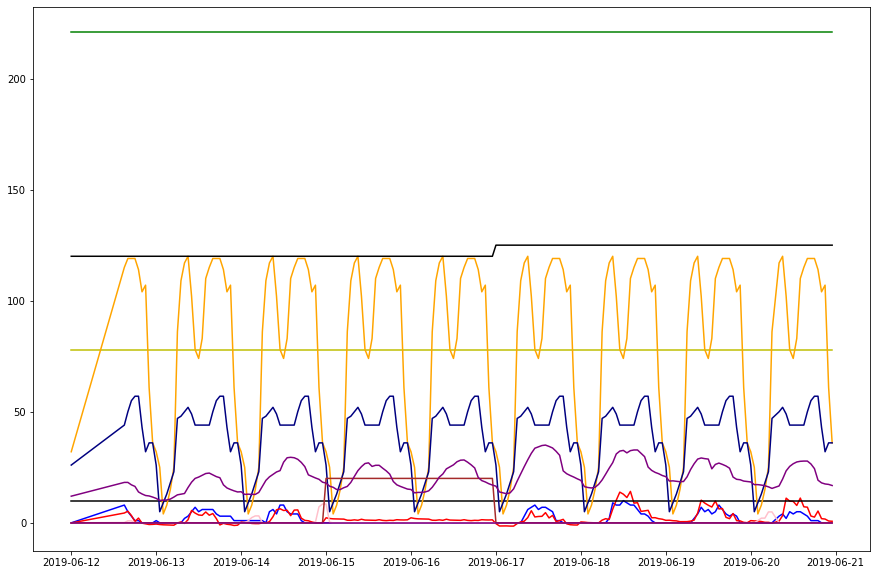

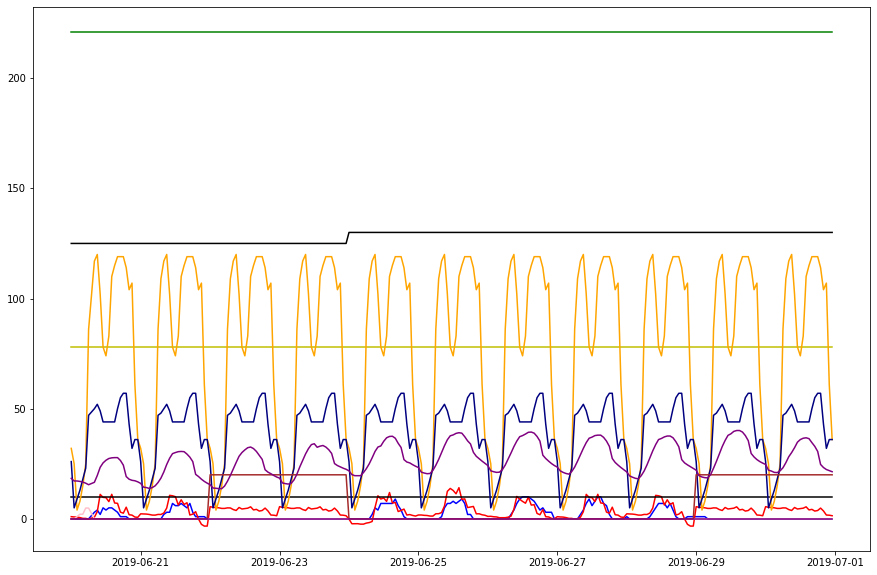

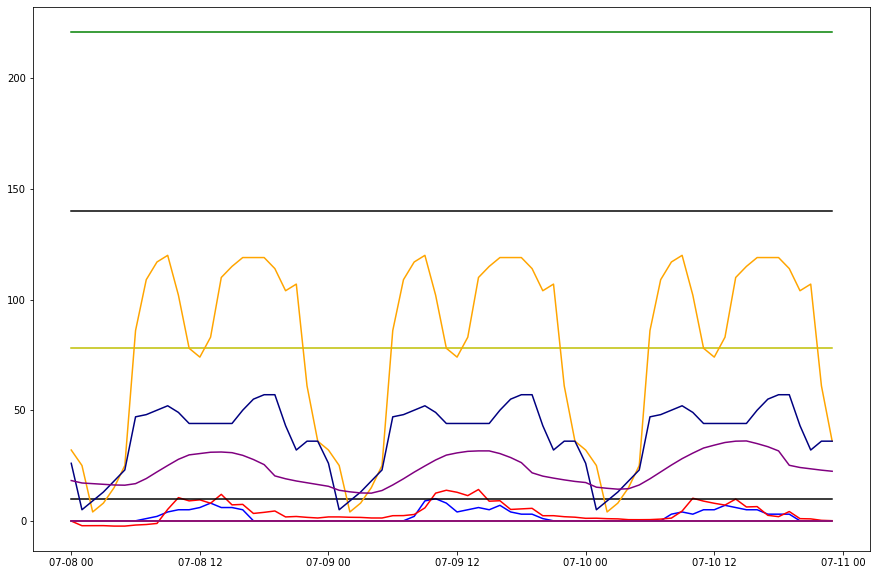

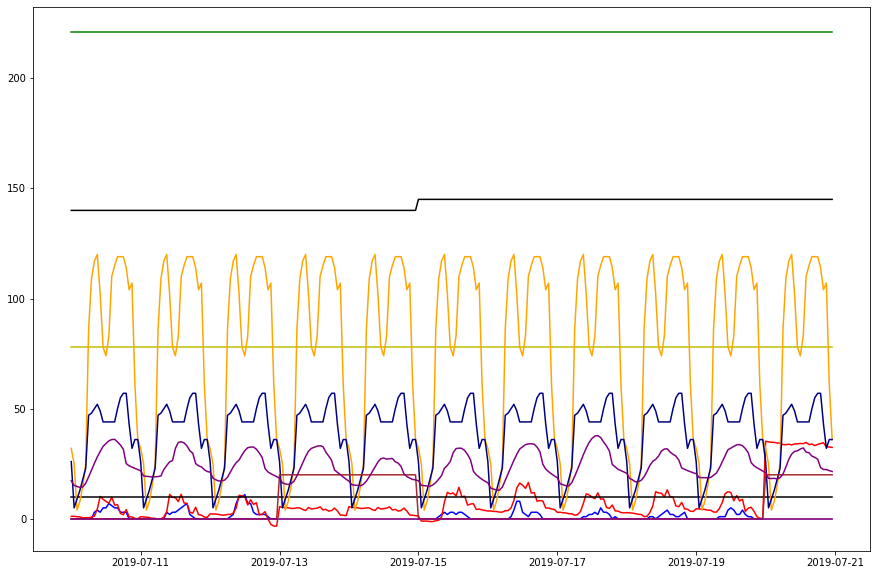

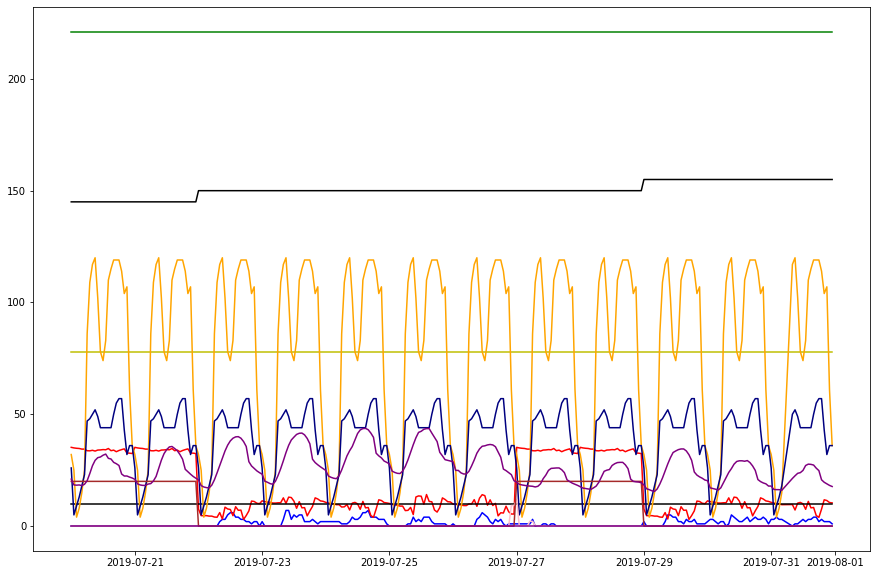

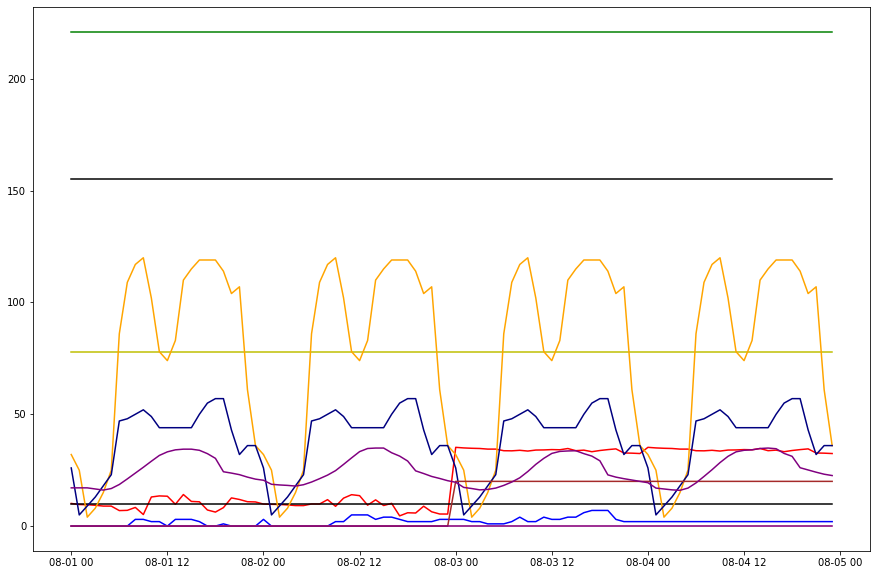

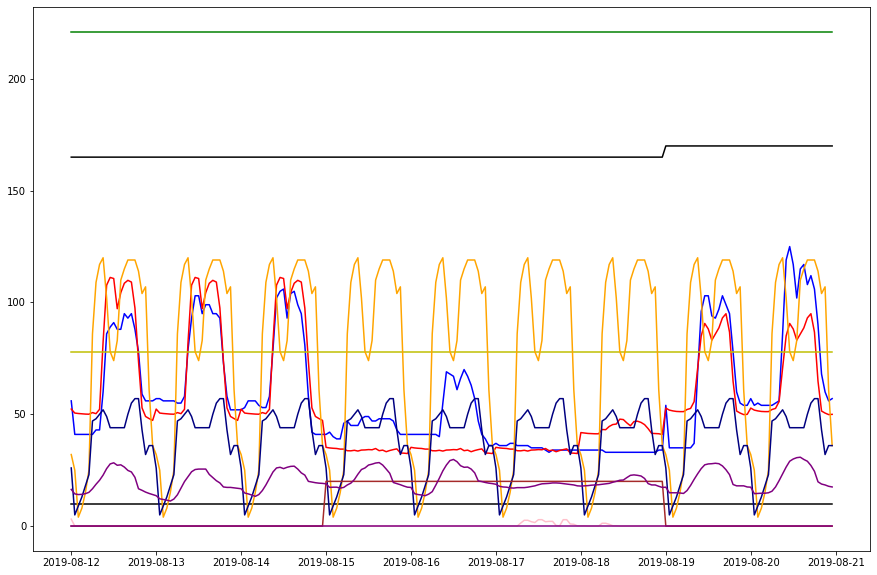

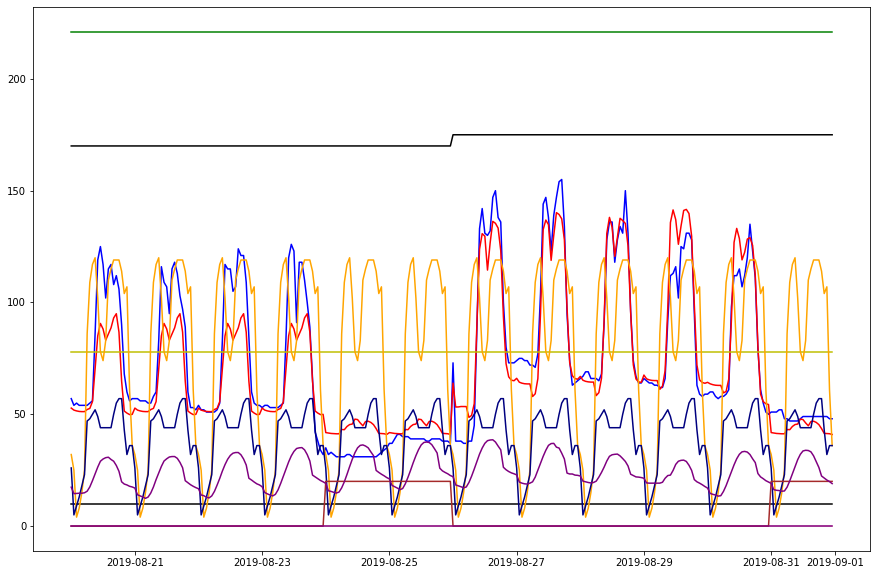

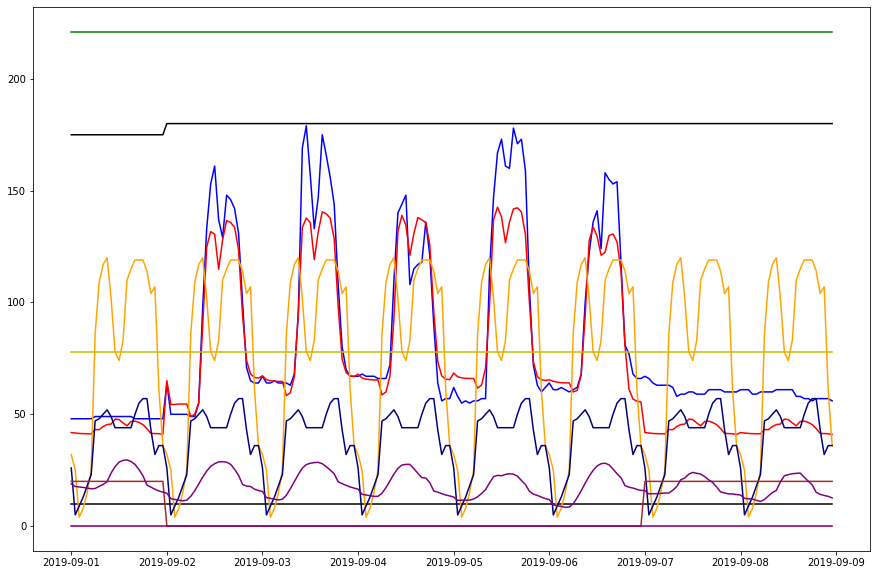

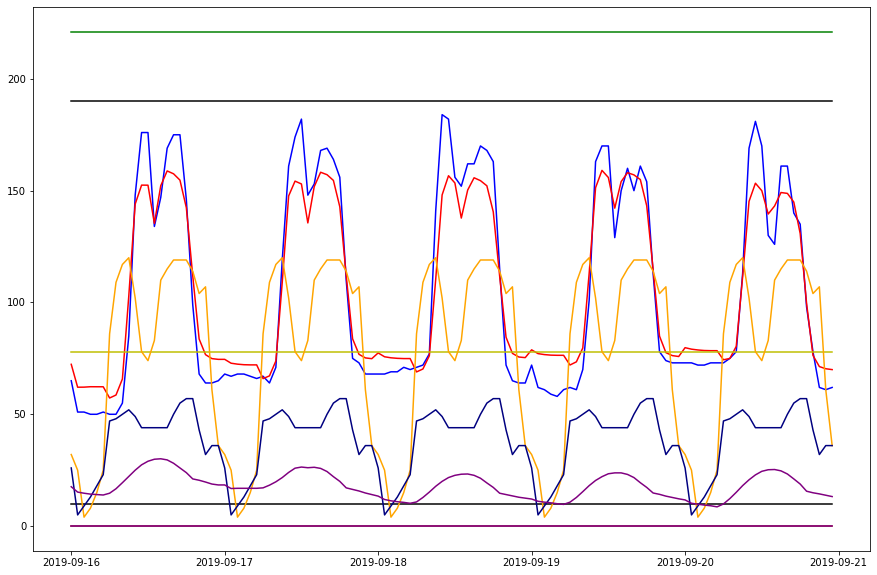

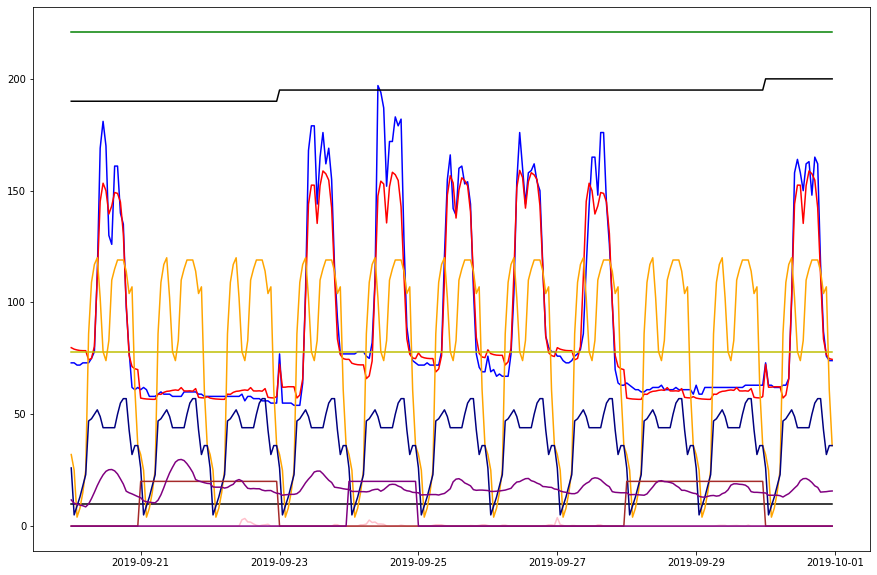

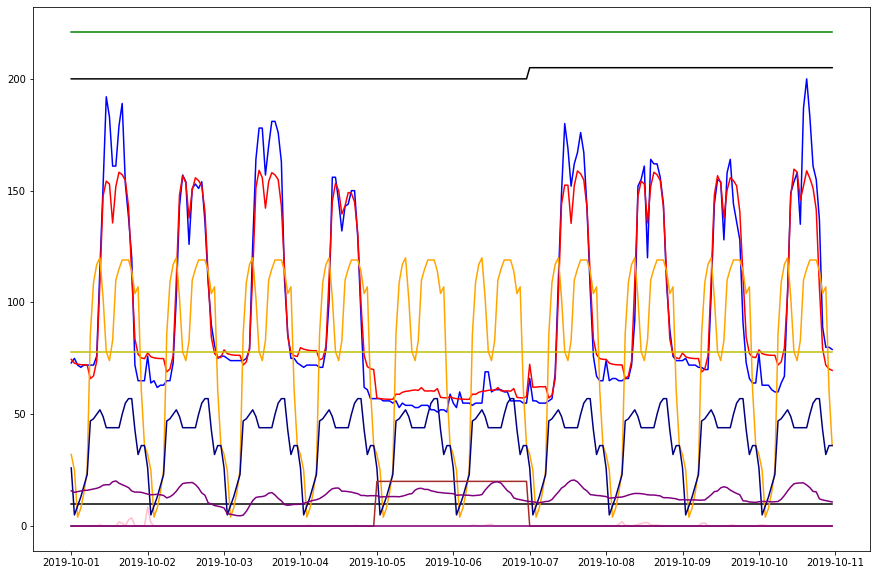

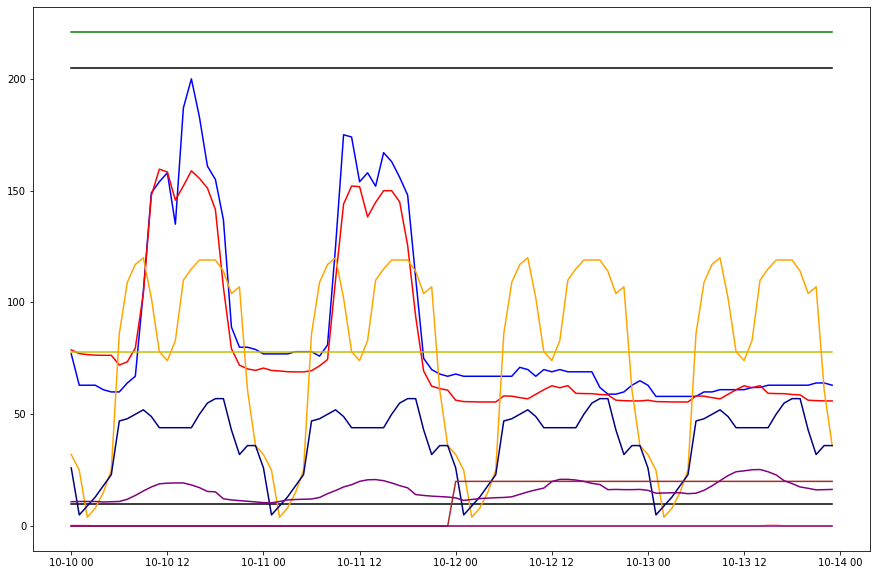

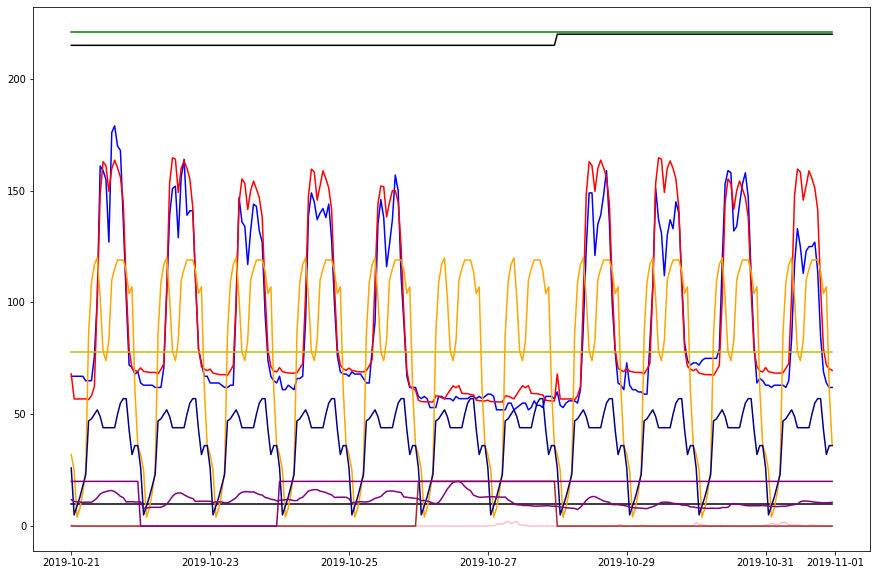

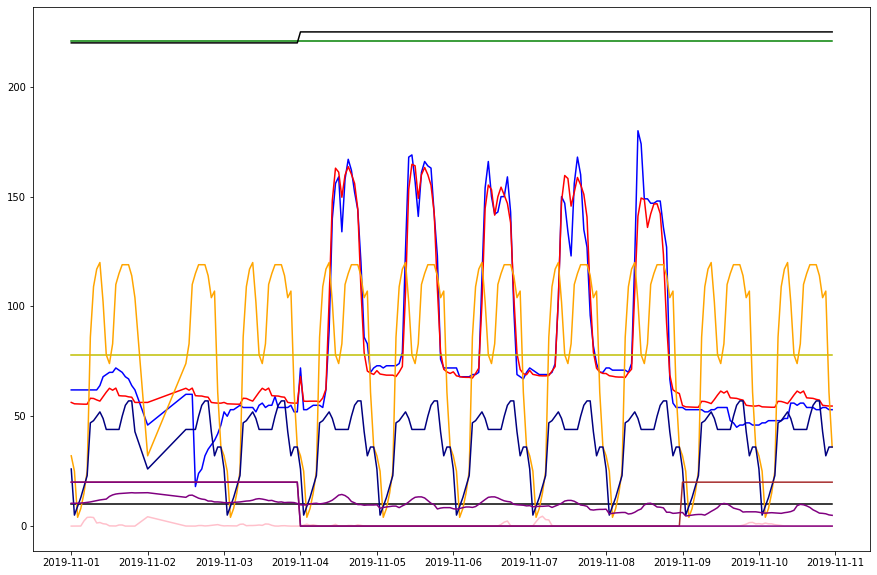

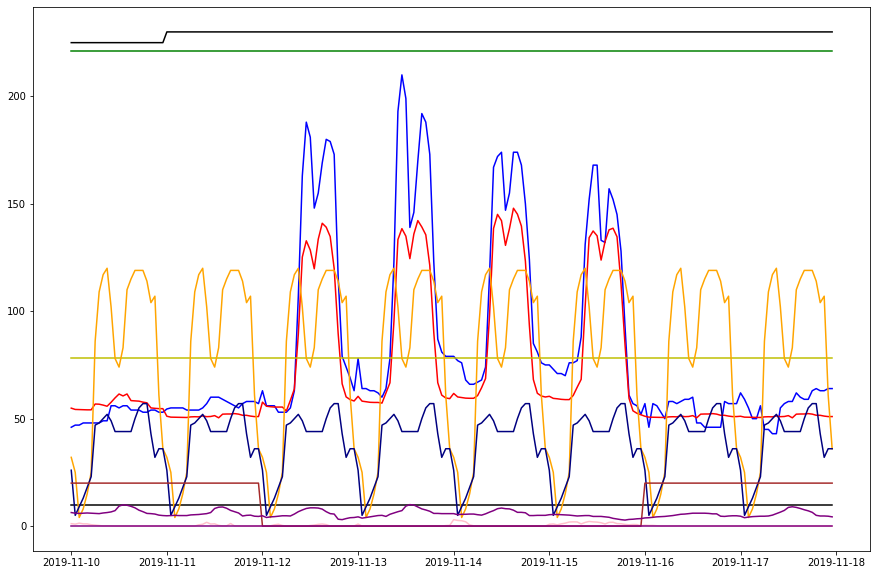

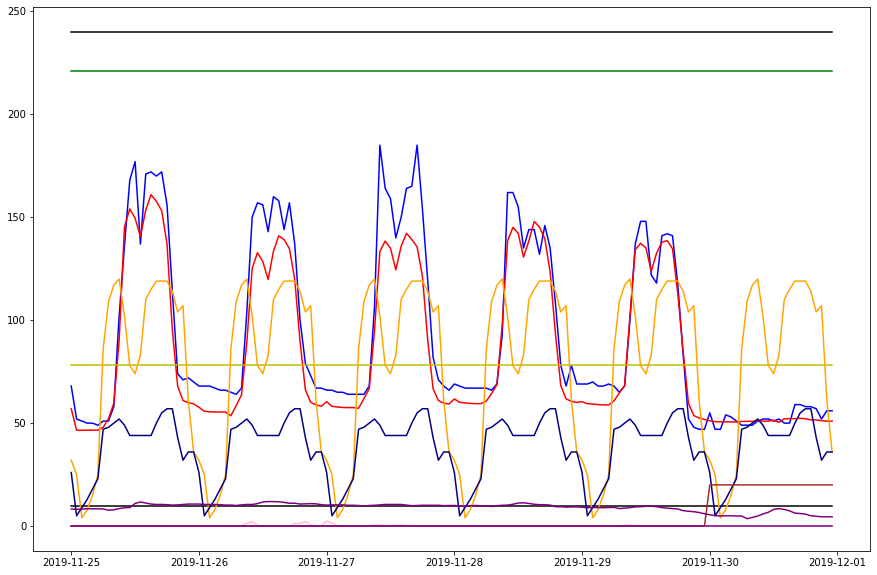

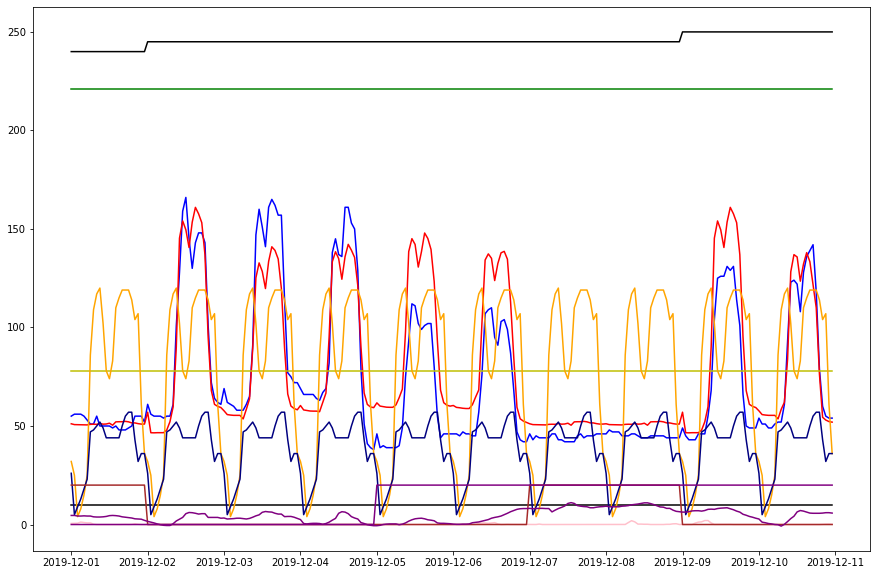

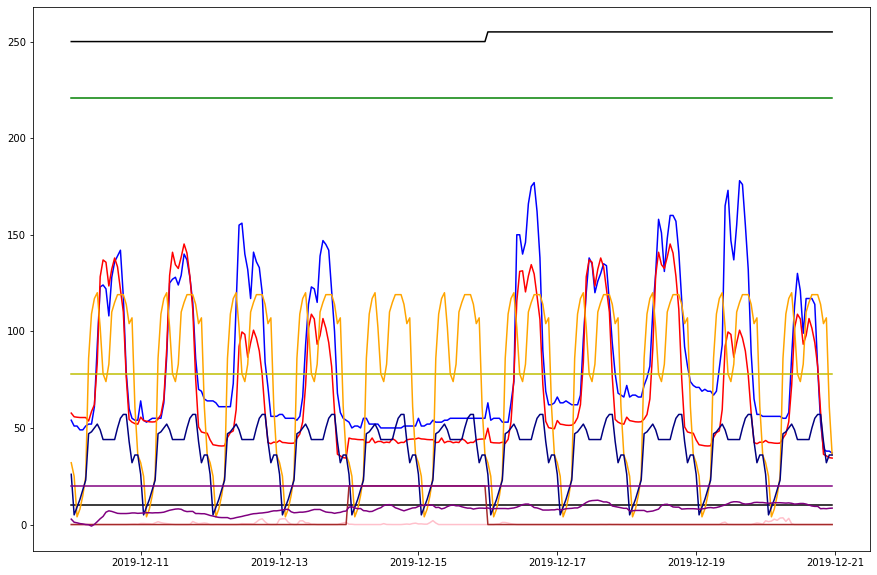

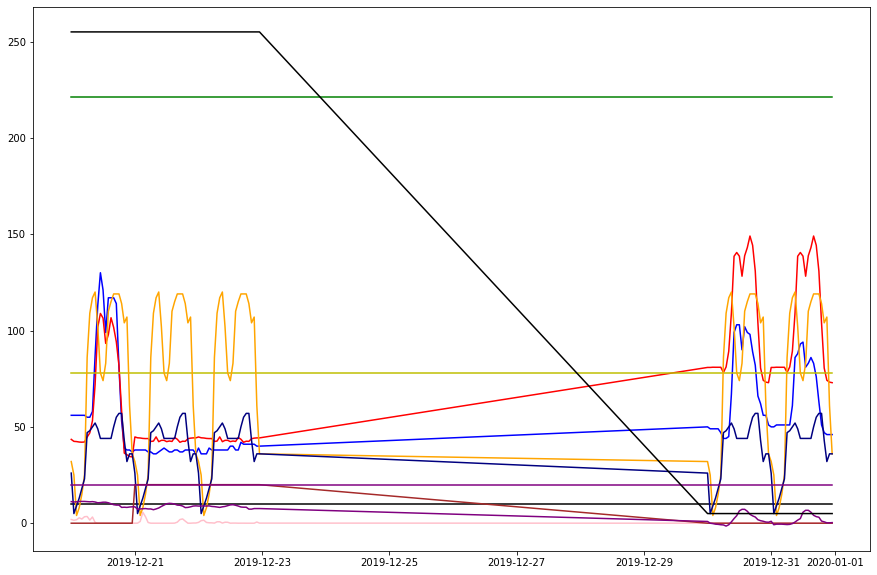

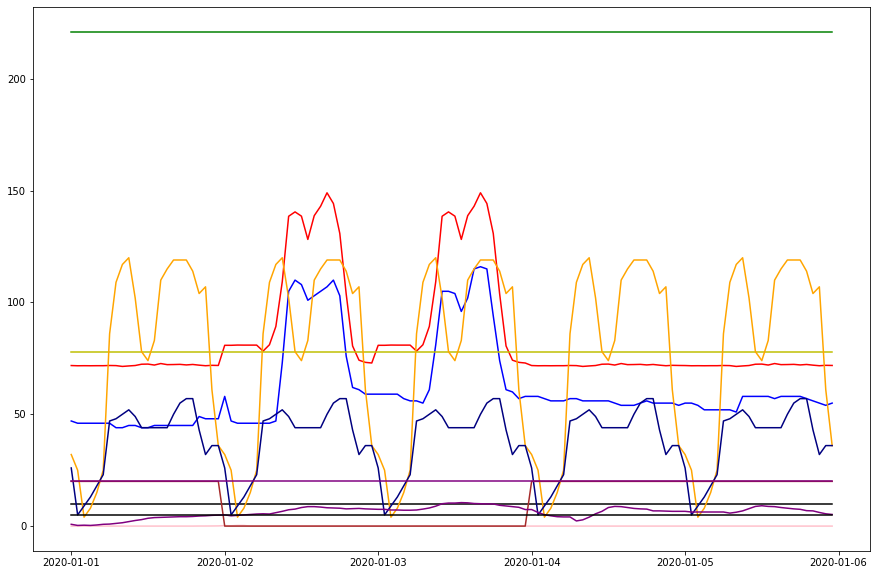

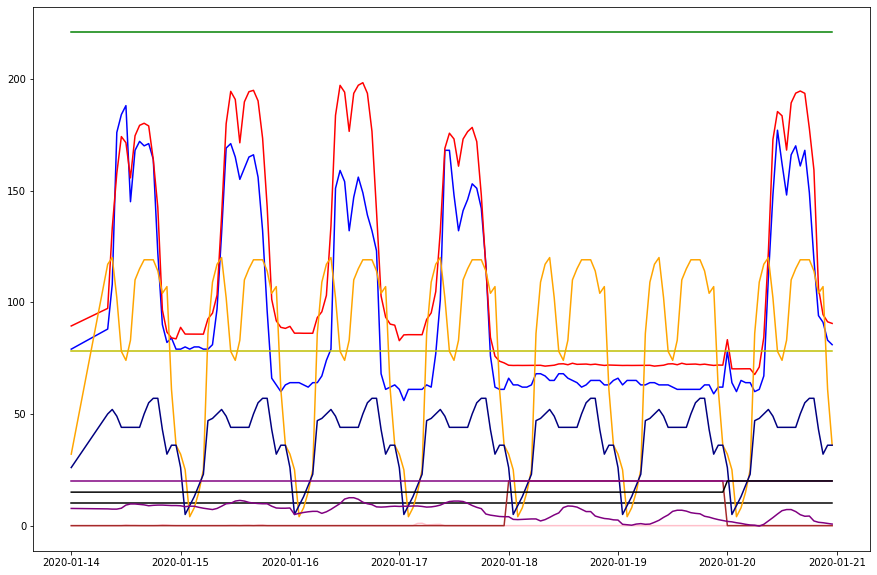

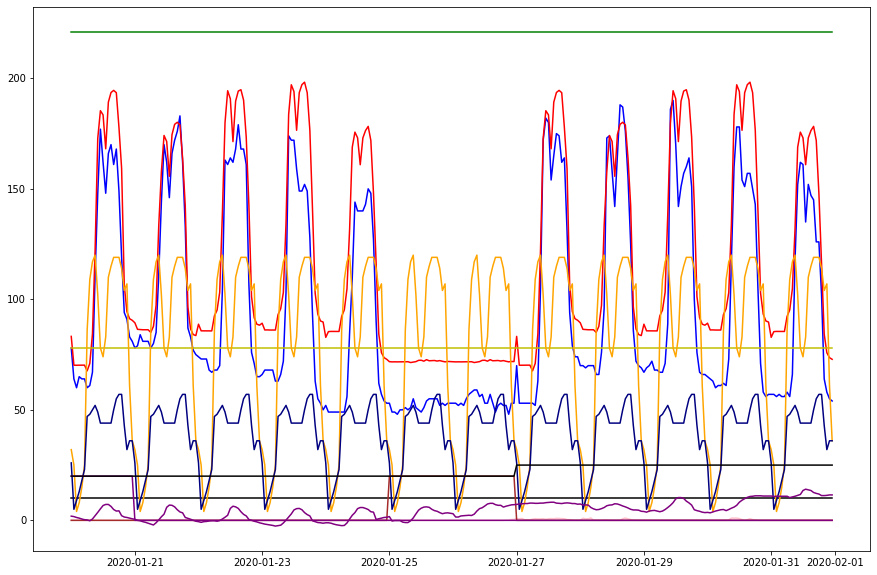

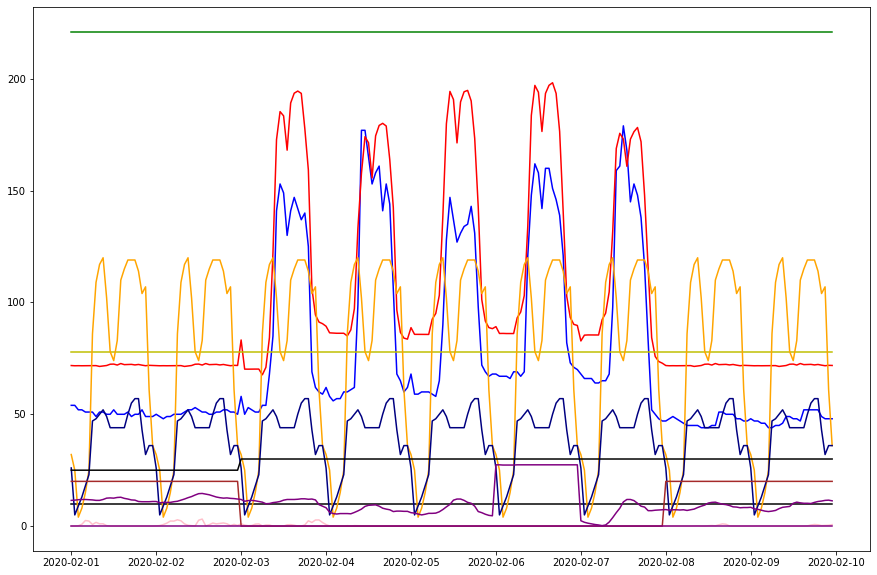

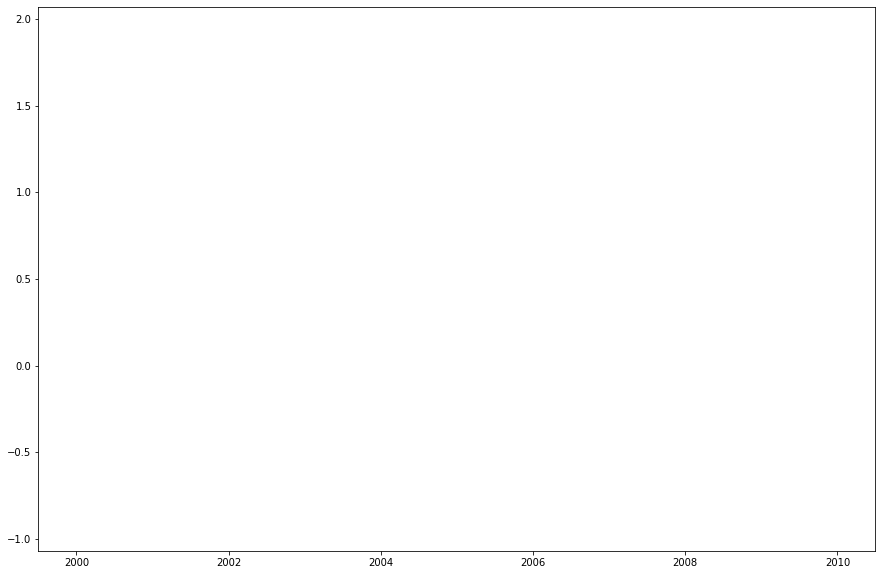

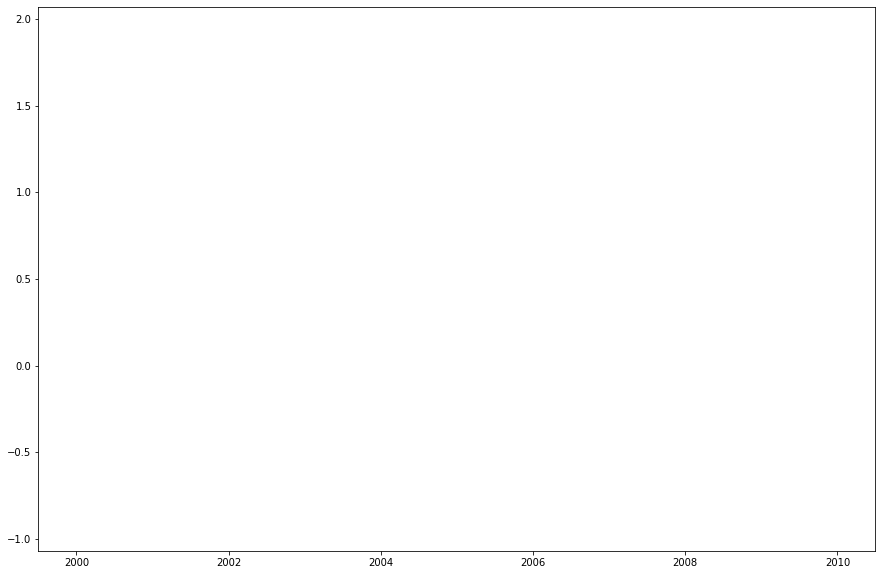

In [10]:
#### Analysing the floor - 
# Blue = Real Attendance
# Red = Predicted Attendance

from matplotlib.backends.backend_pdf import PdfPages

df= df_train
df['prediction'] = prediction


dff = df[(df['building_floor'] == 'T104')]
dff['busday'] = dff['busday'] * 20
dff['strike_day'] = dff['strike_day'] * 20
dff['week_number'] = dff['week_number'] * 5
#dff['is_a_strike_sncf_day'] = dff['is_a_strike_sncf_day'] * 20
#dff['is_a_strike_rapt_day'] = dff['is_a_strike_rapt_day'] * 20
dff['month_str'] = dff['month'].apply(lambda x: '{:02d}'.format(x))
dff['yearmonth'] = dff['year'].astype(str) + dff['month_str']

ym = dff['yearmonth'].unique()

#dff['precipitation'] = dff['precipitation_mm'] * 20
for m in ym:
    i = 0
    f = 10
    dfym = dff[dff['yearmonth'] == m]
    
    while(f <= 32):
        df1 = dfym[(dfym['day'] >= i) & (dfym['day'] <= f)]
        figure = plt.figure()
        plt.plot(df1['date_hour'], df1['attendance'], color='b')
        plt.plot(df1['date_hour'], df1['prediction'], color='r')
        plt.plot(df1['date_hour'], df1['floor_capacity'], color='g')
        plt.plot(df1['date_hour'], df1['meeting_room_capacity'], color='y')
        plt.plot(df1['date_hour'], df1['meeting_room_number'], color='black')
        plt.plot(df1['date_hour'], df1['number_of_metro_1'], color='orange')
        plt.plot(df1['date_hour'], df1['number_of_rer_a'], color='navy')
        plt.plot(df1['date_hour'], df1['precipitation_mm'], color='pink')
        plt.plot(df1['date_hour'], df1['busday'], color='brown')
        plt.plot(df1['date_hour'], df1['strike_day'], color='purple')
        plt.plot(df1['date_hour'], df1['temp_c'], color='purple')
        plt.plot(df1['date_hour'], df1['week_number'], color='black')
        
        plt.rcParams['figure.figsize'] = (15,10)
        plt.show()
        
        i = f
        f = f + 10
        if f == 30:
            f = 32

In [6]:
df_day = df_train.groupby(['building_floor_number', 'date'])[['week_number', 'busday', 'mean_day', 'std_day', 'median_day', 'stops']].first().reset_index()

Looking For the stops periods

In [7]:
pd.set_option('display.max_rows', 500)
df_day[df_day['building_floor_number'] == 4]

,building_floor_number,date,week_number,busday,mean_day,std_day,median_day,stops
944,4,2019-04-12,15,0,137.214286,48.829655,166.0,0
945,4,2019-04-13,15,1,74.083333,1.316011,74.0,2
946,4,2019-04-14,15,1,71.041667,0.204124,71.0,2
947,4,2019-04-15,16,0,124.125000,50.041124,103.5,0
948,4,2019-04-16,16,0,98.818182,17.976753,90.0,0
949,4,2019-04-18,16,0,163.733333,53.833695,191.0,0
950,4,2019-04-19,16,0,114.416667,40.070499,89.5,0
951,4,2019-04-20,16,1,65.000000,0.000000,65.0,2
952,4,2019-04-21,16,1,65.041667,0.204124,65.0,2
953,4,2019-04-29,18,0,107.541667,45.820993,87.5,0


In [8]:
# Stops in business days

df_day[(df_day['stops'] == 1) & (df_day['busday'] == 0)]

,building_floor_number,date,week_number,busday,mean_day,std_day,median_day,stops
240,1,2019-04-16,16,0,0.727273,1.618080,0.0,1
279,1,2019-06-12,24,0,1.400000,1.429841,1.5,1
326,1,2019-08-12,33,0,2.083333,1.742479,1.5,1
327,1,2019-08-13,33,0,1.875000,1.329024,1.0,1
328,1,2019-08-14,33,0,2.375000,1.883856,2.0,1
333,1,2019-08-19,34,0,1.875000,1.423789,1.0,1
334,1,2019-08-20,34,0,2.625000,1.714706,2.5,1
335,1,2019-08-21,34,0,3.291667,3.182550,2.0,1
336,1,2019-08-22,34,0,3.375000,3.932169,1.0,1
337,1,2019-08-23,34,0,2.333333,1.736229,1.5,1


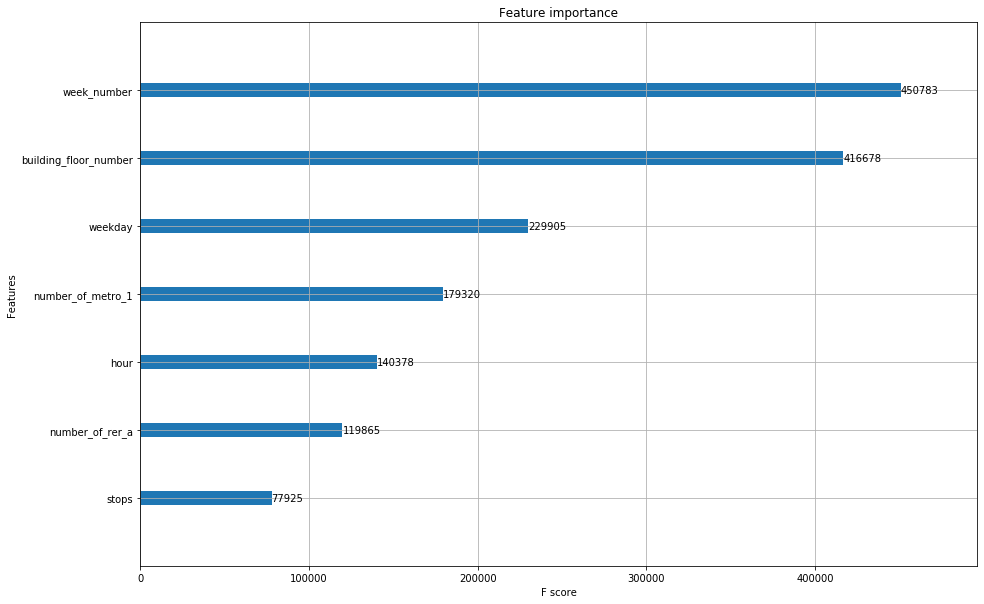

In [18]:
# Plot Feature Importance
xgb.fit(x2,y)
plot_importance(xgb)
plt.show()

In [43]:
from matplotlib.backends.backend_pdf import PdfPages


df= df_train
df['prediction'] = result['prediction']


In [44]:
# Evaluate per floor
floors = df['building_floor'].unique()

for f in floors:
    df_floor = df[df['building_floor'] == f]
    
    print(df_floor.head(1)['building_floor'])
    
    print('MAE:', metrics.mean_absolute_error(df_floor['attendance'], df_floor['prediction']))
    print('RMSE:', sqrt(metrics.mean_squared_error(df_floor['attendance'], df_floor['prediction'])))

0    T100
Name: building_floor, dtype: object
MAE: 8.26135812719606
RMSE: 16.455748540633962
1    T101
Name: building_floor, dtype: object
MAE: 2.7110492796712413
RMSE: 6.943756015938767
2    T102
Name: building_floor, dtype: object
MAE: 4.275511533016573
RMSE: 12.019388205190912
3    T103
Name: building_floor, dtype: object
MAE: 6.216113986399933
RMSE: 10.714790332238918
4    T104
Name: building_floor, dtype: object
MAE: 16.265791730377643
RMSE: 23.389609882152932
5    T105
Name: building_floor, dtype: object
MAE: 17.72503924264153
RMSE: 27.323160004670715
6    T106
Name: building_floor, dtype: object
MAE: 10.227201138510507
RMSE: 15.783454074103766
7    T107
Name: building_floor, dtype: object
MAE: 8.729042513306048
RMSE: 15.651287341957357
8    T108
Name: building_floor, dtype: object
MAE: 32.405018383060366
RMSE: 48.025037594399976
9    T109
Name: building_floor, dtype: object
MAE: 6.633805560955374
RMSE: 12.67916643817911
10    T110
Name: building_floor, dtype: object
MAE: 7.01964

In [28]:
df_train[df_train['busday'] == 1]['weekday'].value_counts()

5    25389
6    25296
2     2232
3      744
0      744
4      651
Name: weekday, dtype: int64

In [41]:
df_train['week_number'].unique()

array([15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35,
       36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51,  1,  3,  4,  5,
        6], dtype=int64)

# Submission

In [3]:
#### Preparing Test Data
df_test = dp.data_prep('GBS Building Attendance  - Test.csv')

Starting....
Running....
Finished....


In [4]:
df_test['week_number'].unique()

array([17, 22, 27, 32, 37, 42, 47, 52,  2,  7], dtype=int64)

In [10]:
df_test['id'] = df_test.index

In [11]:
floors_train = df_train['building_floor_number'].unique()
floors_test = df_test['building_floor_number'].unique()

In [12]:
# Split unknown and knew floors.

df_in = pd.DataFrame()
df_out = pd.DataFrame()

for f in floors_test:
    df_fl = df_test[df_test['building_floor_number'] == f]
    
    if f in floors_train:
        df_in = df_in.append(df_fl)
    else: 
        df_out = df_out.append(df_fl)

In [13]:
# Grouping by day to test in the function set_stops, testing with previous and forward weeks

df_day = df_train.groupby(['building_floor_number', 'date'])[['week_number', 'busday', 'mean_day', 'std_day', 'median_day', 'stops']].first().reset_index()

In [14]:
# function to set stop or not in the weeks of test dataset

def set_stops(df):
    if df['busday'] == 1:
        return 1
    
    df_floor = df_day[(df_day['building_floor_number'] == df['building_floor_number']) & (df_day['busday'] == 0)]
    
    before = df_floor[df_floor['week_number'] == df['week_number'] - 1].tail(1)['stops'].values[0]
    
    if df['week_number'] == 52:
        after = df_floor[df_floor['week_number'] == 1].head(1)['stops'].values[0]
    elif df['week_number'] != 7:
        after = df_floor[df_floor['week_number'] == df['week_number'] + 1].head(1)['stops'].values[0]
    else:
        after = before
       
    stop = after
        
    
    return stop

In [15]:
df_in['stops'] = df_in[['building_floor_number', 'week_number', 'busday']].apply(set_stops, axis=1)

In [16]:
df_in['stops'].value_counts()

0    31008
1    19677
Name: stops, dtype: int64

In [17]:
# appending the dataframes
df_out['stops'] = df_out['busday']
df_test2 = df_out.append(df_in)

In [18]:
df_test2 = df_test2.sort_values('id')

In [19]:
df_test2['stops'] = df_test2[['busday', 'stops']].apply(stops_busday, axis=1)

In [20]:
df_test2['stops'].value_counts()

0    37632
2    19647
1     3216
Name: stops, dtype: int64

In [21]:
#### Feature selection for Prediction
#x_test = df_out[['building_floor_number', 'number_of_metro_1', 'number_of_rer_a', 'hour', 'busday', 'week_number', 'weekday']]
#x_test2 = df_in[['building_floor_number', 'number_of_metro_1', 'number_of_rer_a', 'hour', 'busday', 'week_number', 'weekday',  'stops']]

x_test2 = df_test2[['building_floor_number', 'number_of_metro_1', 'number_of_rer_a', 'hour', 'week_number', 'weekday',  'stops']]


In [22]:
# Fit with the complete df_train and Predict df_test
### XGBoost
'''
xgb = XGBRegressor(colsample_bytree=0.9, 
                   gamma=0.3, 
                   max_depth=9, 
                   min_chils_weight=4, 
                   subsample=1,
                   n_estimators=40,
                   nthread=-1, 
                   learning_rate=0.3,
                   num_parallel_tree=90,
                   importance_type='gain',
                   eval_metric='rmse')
xgb.fit(x,y)
'''

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0.3, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
             max_depth=9, min_child_weight=1, min_chils_weight=4, missing=nan,
             monotone_constraints=None, n_estimators=40, n_jobs=-1, nthread=-1,
             num_parallel_tree=90, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [23]:
xgb2 = XGBRegressor(colsample_bytree=0.9, 
                   gamma=0.3, 
                   max_depth=9, 
                   min_chils_weight=4, 
                   subsample=1,
                   n_estimators=40,
                   nthread=-1,
                   learning_rate=0.3,
                   num_parallel_tree=90,
                   importance_type='gain',
                   eval_metric='rmse')
xgb2.fit(x2,y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0.3, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
             max_depth=9, min_child_weight=1, min_chils_weight=4, missing=nan,
             monotone_constraints=None, n_estimators=40, n_jobs=-1, nthread=-1,
             num_parallel_tree=90, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [24]:
#prediction = xgb.predict(x_test).astype(int)
prediction2 = xgb2.predict(x_test2).astype(int)


In [25]:
#df_out['Prediction'] = prediction
#df_in['Prediction'] = prediction2

df_test2['Prediction'] = prediction2

#df_result = df_out.append(df_in)

In [26]:
#df_result['Prediction'] = df_result['Prediction'].apply(lambda x: x if x > 0 else 0)
df_test2['Prediction'] = df_test2['Prediction'].apply(lambda x: x if x > 0 else 0)

In [27]:
#df_result = df_result.sort_values('id')

In [28]:
#df_result['Prediction'].to_csv('submission_29.csv', index=False, header=False)
df_test2['Prediction'].to_csv('submission_29.csv', index=False, header=False)